## Importation des Bibliothèques

In [1]:
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np # linear algebra
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
import plotly.express as px
import plotly.offline as py
from wordcloud import WordCloud
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.base import TransformerMixin
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import confusion_matrix

import re
from nltk.tokenize import word_tokenize
!pip install pyspellchecker
from spellchecker import SpellChecker
import time
from multiprocessing import  Pool
from nltk.stem import WordNetLemmatizer 
import nltk
nltk.download('punkt')
import os

[nltk_data] Downloading package punkt to /home/wolf/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [39]:
# cleaning our data (cleaning our tweet text)
# https://www.kaggle.com/jdparsons/tweet-cleaner
def untokenize(words):
    """Untokenizing a text undoes the tokenizing operation, restoring
    punctuation and spaces to the places that people expect them to be.
    Ideally, `untokenize(tokenize(text))` should be identical to `text`,
    except for line breaks.
    """
    text = ' '.join(words)
    step1 = text.replace("`` ", '"').replace(" ''", '"').replace('. . .', '...')
    step2 = step1.replace(" ( ", " (").replace(" ) ", ") ")
    step3 = re.sub(r' ([.,:;?!%]+)([ \'"`])', r"\1\2", step2)
    step4 = re.sub(r' ([.,:;?!%]+)$', r"\1", step3)
    step5 = step4.replace(" '", "'").replace(" n't", "n't").replace(
        "can not", "cannot")
    step6 = step5.replace(" ` ", " '")
    return step6.strip()


# https://stackoverflow.com/a/47091490
def decontracted(phrase):
    """Convert contractions like "can't" into "can not"
    """
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    #phrase = re.sub(r"n't", " not", phrase) # resulted in "ca not" when sentence started with "can't"
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase


# https://github.com/rishabhverma17/sms_slang_translator/blob/master/slang.txt
slang_abbrev_dict = {
    'AFAIK': 'As Far As I Know',
    'AFK': 'Away From Keyboard',
    'ASAP': 'As Soon As Possible',
    'ATK': 'At The Keyboard',
    'ATM': 'At The Moment',
    'A3': 'Anytime, Anywhere, Anyplace',
    'BAK': 'Back At Keyboard',
    'BBL': 'Be Back Later',
    'BBS': 'Be Back Soon',
    'BFN': 'Bye For Now',
    'B4N': 'Bye For Now',
    'BRB': 'Be Right Back',
    'BRT': 'Be Right There',
    'BTW': 'By The Way',
    'B4': 'Before',
    'B4N': 'Bye For Now',
    'CU': 'See You',
    'CUL8R': 'See You Later',
    'CYA': 'See You',
    'FAQ': 'Frequently Asked Questions',
    'FC': 'Fingers Crossed',
    'FWIW': 'For What It\'s Worth',
    'FYI': 'For Your Information',
    'GAL': 'Get A Life',
    'GG': 'Good Game',
    'GN': 'Good Night',
    'GMTA': 'Great Minds Think Alike',
    'GR8': 'Great!',
    'G9': 'Genius',
    'IC': 'I See',
    'ICQ': 'I Seek you',
    'ILU': 'I Love You',
    'IMHO': 'In My Humble Opinion',
    'IMO': 'In My Opinion',
    'IOW': 'In Other Words',
    'IRL': 'In Real Life',
    'KISS': 'Keep It Simple, Stupid',
    'LDR': 'Long Distance Relationship',
    'LMAO': 'Laugh My Ass Off',
    'LOL': 'Laughing Out Loud',
    'LTNS': 'Long Time No See',
    'L8R': 'Later',
    'MTE': 'My Thoughts Exactly',
    'M8': 'Mate',
    'NRN': 'No Reply Necessary',
    'OIC': 'Oh I See',
    'OMG': 'Oh My God',
    'PITA': 'Pain In The Ass',
    'PRT': 'Party',
    'PRW': 'Parents Are Watching',
    'QPSA?': 'Que Pasa?',
    'ROFL': 'Rolling On The Floor Laughing',
    'ROFLOL': 'Rolling On The Floor Laughing Out Loud',
    'ROTFLMAO': 'Rolling On The Floor Laughing My Ass Off',
    'SK8': 'Skate',
    'STATS': 'Your sex and age',
    'ASL': 'Age, Sex, Location',
    'THX': 'Thank You',
    'TTFN': 'Ta-Ta For Now!',
    'TTYL': 'Talk To You Later',
    'U': 'You',
    'U2': 'You Too',
    'U4E': 'Yours For Ever',
    'WB': 'Welcome Back',
    'WTF': 'What The Fuck',
    'WTG': 'Way To Go!',
    'WUF': 'Where Are You From?',
    'W8': 'Wait',
    '7K': 'Sick:-D Laugher'
}


def unslang(text):
    """Converts text like "OMG" into "Oh my God"
    """
    if text.upper() in slang_abbrev_dict.keys():
        return slang_abbrev_dict[text.upper()]
    else:
        return text


# https://gist.github.com/sebleier/554280
stopwords = [
    "a", "about", "above", "after", "again", "against", "ain", "all", "am",
    "an", "and", "any", "are", "aren", "aren't", "as", "at", "be", "because",
    "been", "before", "being", "below", "between", "both", "but", "by", "can",
    "couldn", "couldn't", "d", "did", "didn", "didn't", "do", "does", "doesn",
    "doesn't", "doing", "don", "don't", "down", "during", "each", "few", "for",
    "from", "further", "had", "hadn", "hadn't", "has", "hasn", "hasn't", "have",
    "haven", "haven't", "having", "he", "her", "here", "hers", "herself", "him",
    "himself", "his", "how", "i", "if", "in", "into", "is", "isn", "isn't",
    "it", "it's", "its", "itself", "just", "ll", "m", "ma", "me", "mightn",
    "mightn't", "more", "most", "mustn", "mustn't", "my", "myself", "needn",
    "needn't", "no", "nor", "not", "now", "o", "of", "off", "on", "once",
    "only", "or", "other", "our", "ours", "ourselves", "out", "over", "own",
    "re", "s", "same", "shan", "shan't", "she", "she's", "should", "should've",
    "shouldn", "shouldn't", "so", "some", "such", "t", "than", "that",
    "that'll", "the", "their", "theirs", "them", "themselves", "then", "there",
    "these", "they", "this", "those", "through", "to", "too", "under", "until",
    "up", "ve", "very", "was", "wasn", "wasn't", "we", "were", "weren",
    "weren't", "what", "when", "where", "which", "while", "who", "whom", "why",
    "will", "with", "won", "won't", "wouldn", "wouldn't", "y", "you", "you'd",
    "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves",
    "could", "he'd", "he'll", "he's", "here's", "how's", "i'd", "i'll", "i'm",
    "i've", "let's", "ought", "she'd", "she'll", "that's", "there's", "they'd",
    "they'll", "they're", "they've", "we'd", "we'll", "we're", "we've",
    "what's", "when's", "where's", "who's", "why's", "would", "able", "abst",
    "accordance", "according", "accordingly", "across", "act", "actually",
    "added", "adj", "affected", "affecting", "affects", "afterwards", "ah",
    "almost", "alone", "along", "already", "also", "although", "always",
    "among", "amongst", "announce", "another", "anybody", "anyhow", "anymore",
    "anyone", "anything", "anyway", "anyways", "anywhere", "apparently",
    "approximately", "arent", "arise", "around", "aside", "ask", "asking",
    "auth", "available", "away", "awfully", "b", "back", "became", "become",
    "becomes", "becoming", "beforehand", "begin", "beginning", "beginnings",
    "begins", "behind", "believe", "beside", "besides", "beyond", "biol",
    "brief", "briefly", "c", "ca", "came", "cannot", "can't", "cause", "causes",
    "certain", "certainly", "co", "com", "come", "comes", "contain",
    "containing", "contains", "couldnt", "date", "different", "done",
    "downwards", "due", "e", "ed", "edu", "effect", "eg", "eight", "eighty",
    "either", "else", "elsewhere", "end", "ending", "enough", "especially",
    "et", "etc", "even", "ever", "every", "everybody", "everyone", "everything",
    "everywhere", "ex", "except", "f", "far", "ff", "fifth", "first", "five",
    "fix", "followed", "following", "follows", "former", "formerly", "forth",
    "found", "four", "furthermore", "g", "gave", "get", "gets", "getting",
    "give", "given", "gives", "giving", "go", "goes", "gone", "got", "gotten",
    "h", "happens", "hardly", "hed", "hence", "hereafter", "hereby", "herein",
    "heres", "hereupon", "hes", "hi", "hid", "hither", "home", "howbeit",
    "however", "hundred", "id", "ie", "im", "immediate", "immediately",
    "importance", "important", "inc", "indeed", "index", "information",
    "instead", "invention", "inward", "itd", "it'll", "j", "k", "keep", "keeps",
    "kept", "kg", "km", "know", "known", "knows", "l", "largely", "last",
    "lately", "later", "latter", "latterly", "least", "less", "lest", "let",
    "lets", "like", "liked", "likely", "line", "little", "'ll", "look",
    "looking", "looks", "ltd", "made", "mainly", "make", "makes", "many", "may",
    "maybe", "mean", "means", "meantime", "meanwhile", "merely", "mg", "might",
    "million", "miss", "ml", "moreover", "mostly", "mr", "mrs", "much", "mug",
    "must", "n", "na", "name", "namely", "nay", "nd", "near", "nearly",
    "necessarily", "necessary", "need", "needs", "neither", "never",
    "nevertheless", "new", "next", "nine", "ninety", "nobody", "non", "none",
    "nonetheless", "noone", "normally", "nos", "noted", "nothing", "nowhere",
    "obtain", "obtained", "obviously", "often", "oh", "ok", "okay", "old",
    "omitted", "one", "ones", "onto", "ord", "others", "otherwise", "outside",
    "overall", "owing", "p", "page", "pages", "part", "particular",
    "particularly", "past", "per", "perhaps", "placed", "please", "plus",
    "poorly", "possible", "possibly", "potentially", "pp", "predominantly",
    "present", "previously", "primarily", "probably", "promptly", "proud",
    "provides", "put", "q", "que", "quickly", "quite", "qv", "r", "ran",
    "rather", "rd", "readily", "really", "recent", "recently", "ref", "refs",
    "regarding", "regardless", "regards", "related", "relatively", "research",
    "respectively", "resulted", "resulting", "results", "right", "run", "said",
    "saw", "say", "saying", "says", "sec", "section", "see", "seeing", "seem",
    "seemed", "seeming", "seems", "seen", "self", "selves", "sent", "seven",
    "several", "shall", "shed", "shes", "show", "showed", "shown", "showns",
    "shows", "significant", "significantly", "similar", "similarly", "since",
    "six", "slightly", "somebody", "somehow", "someone", "somethan",
    "something", "sometime", "sometimes", "somewhat", "somewhere", "soon",
    "sorry", "specifically", "specified", "specify", "specifying", "still",
    "stop", "strongly", "sub", "substantially", "successfully", "sufficiently",
    "suggest", "sup", "sure", "take", "taken", "taking", "tell", "tends", "th",
    "thank", "thanks", "thanx", "thats", "that've", "thence", "thereafter",
    "thereby", "thered", "therefore", "therein", "there'll", "thereof",
    "therere", "theres", "thereto", "thereupon", "there've", "theyd", "theyre",
    "think", "thou", "though", "thoughh", "thousand", "throug", "throughout",
    "thru", "thus", "til", "tip", "together", "took", "toward", "towards",
    "tried", "tries", "truly", "try", "trying", "ts", "twice", "two", "u", "un",
    "unfortunately", "unless", "unlike", "unlikely", "unto", "upon", "ups",
    "us", "use", "used", "useful", "usefully", "usefulness", "uses", "using",
    "usually", "v", "value", "various", "'ve", "via", "viz", "vol", "vols",
    "vs", "w", "want", "wants", "wasnt", "way", "wed", "welcome", "went",
    "werent", "whatever", "what'll", "whats", "whence", "whenever",
    "whereafter", "whereas", "whereby", "wherein", "wheres", "whereupon",
    "wherever", "whether", "whim", "whither", "whod", "whoever", "whole",
    "who'll", "whomever", "whos", "whose", "widely", "willing", "wish",
    "within", "without", "wont", "words", "world", "wouldnt", "www", "x", "yes",
    "yet", "youd", "youre", "z", "zero", "a's", "ain't", "allow", "allows",
    "apart", "appear", "appreciate", "appropriate", "associated", "best",
    "better", "c'mon", "c's", "cant", "changes", "clearly", "concerning",
    "consequently", "consider", "considering", "corresponding", "course",
    "currently", "definitely", "described", "despite", "entirely", "exactly",
    "example", "going", "greetings", "hello", "help", "hopefully", "ignored",
    "inasmuch", "indicate", "indicated", "indicates", "inner", "insofar",
    "it'd", "keep", "keeps", "novel", "presumably", "reasonably", "second",
    "secondly", "sensible", "serious", "seriously", "sure", "t's", "third",
    "thorough", "thoroughly", "three", "well", "wonder", "a", "about", "above",
    "above", "across", "after", "afterwards", "again", "against", "all",
    "almost", "alone", "along", "already", "also", "although", "always", "am",
    "among", "amongst", "amoungst", "amount", "an", "and", "another", "any",
    "anyhow", "anyone", "anything", "anyway", "anywhere", "are", "around", "as",
    "at", "back", "be", "became", "because", "become", "becomes", "becoming",
    "been", "before", "beforehand", "behind", "being", "below", "beside",
    "besides", "between", "beyond", "bill", "both", "bottom", "but", "by",
    "call", "can", "cannot", "cant", "co", "con", "could", "couldnt", "cry",
    "de", "describe", "detail", "do", "done", "down", "due", "during", "each",
    "eg", "eight", "either", "eleven", "else", "elsewhere", "empty", "enough",
    "etc", "even", "ever", "every", "everyone", "everything", "everywhere",
    "except", "few", "fifteen", "fify", "fill", "find", "fire", "first", "five",
    "for", "former", "formerly", "forty", "found", "four", "from", "front",
    "full", "further", "get", "give", "go", "had", "has", "hasnt", "have", "he",
    "hence", "her", "here", "hereafter", "hereby", "herein", "hereupon", "hers",
    "herself", "him", "himself", "his", "how", "however", "hundred", "ie", "if",
    "in", "inc", "indeed", "interest", "into", "is", "it", "its", "itself",
    "keep", "last", "latter", "latterly", "least", "less", "ltd", "made",
    "many", "may", "me", "meanwhile", "might", "mill", "mine", "more",
    "moreover", "most", "mostly", "move", "much", "must", "my", "myself",
    "name", "namely", "neither", "never", "nevertheless", "next", "nine", "no",
    "nobody", "none", "noone", "nor", "not", "nothing", "now", "nowhere", "of",
    "off", "often", "on", "once", "one", "only", "onto", "or", "other",
    "others", "otherwise", "our", "ours", "ourselves", "out", "over", "own",
    "part", "per", "perhaps", "please", "put", "rather", "re", "same", "see",
    "seem", "seemed", "seeming", "seems", "serious", "several", "she", "should",
    "show", "side", "since", "sincere", "six", "sixty", "so", "some", "somehow",
    "someone", "something", "sometime", "sometimes", "somewhere", "still",
    "such", "system", "take", "ten", "than", "that", "the", "their", "them",
    "themselves", "then", "thence", "there", "thereafter", "thereby",
    "therefore", "therein", "thereupon", "these", "they", "thickv", "thin",
    "third", "this", "those", "though", "three", "through", "throughout",
    "thru", "thus", "to", "together", "too", "top", "toward", "towards",
    "twelve", "twenty", "two", "un", "under", "until", "up", "upon", "us",
    "very", "via", "was", "we", "well", "were", "what", "whatever", "when",
    "whence", "whenever", "where", "whereafter", "whereas", "whereby",
    "wherein", "whereupon", "wherever", "whether", "which", "while", "whither",
    "who", "whoever", "whole", "whom", "whose", "why", "will", "with", "within",
    "without", "would", "yet", "you", "your", "yours", "yourself", "yourselves",
    "the", "a", "b", "c", "d", "e", "f", "g", "h", "i", "j", "k", "l", "m", "n",
    "o", "p", "q", "r", "s", "t", "u", "v", "w", "x", "y", "z", "A", "B", "C",
    "D", "E", "F", "G", "H", "I", "J", "K", "L", "M", "N", "O", "P", "Q", "R",
    "S", "T", "U", "V", "W", "X", "Y", "Z", "co", "op", "research-articl",
    "pagecount", "cit", "ibid", "les", "le", "au", "que", "est", "pas", "vol",
    "el", "los", "pp", "u201d", "well-b", "http", "volumtype", "par", "0o",
    "0s", "3a", "3b", "3d", "6b", "6o", "a1", "a2", "a3", "a4", "ab", "ac",
    "ad", "ae", "af", "ag", "aj", "al", "an", "ao", "ap", "ar", "av", "aw",
    "ax", "ay", "az", "b1", "b2", "b3", "ba", "bc", "bd", "be", "bi", "bj",
    "bk", "bl", "bn", "bp", "br", "bs", "bt", "bu", "bx", "c1", "c2", "c3",
    "cc", "cd", "ce", "cf", "cg", "ch", "ci", "cj", "cl", "cm", "cn", "cp",
    "cq", "cr", "cs", "ct", "cu", "cv", "cx", "cy", "cz", "d2", "da", "dc",
    "dd", "de", "df", "di", "dj", "dk", "dl", "do", "dp", "dr", "ds", "dt",
    "du", "dx", "dy", "e2", "e3", "ea", "ec", "ed", "ee", "ef", "ei", "ej",
    "el", "em", "en", "eo", "ep", "eq", "er", "es", "et", "eu", "ev", "ex",
    "ey", "f2", "fa", "fc", "ff", "fi", "fj", "fl", "fn", "fo", "fr", "fs",
    "ft", "fu", "fy", "ga", "ge", "gi", "gj", "gl", "go", "gr", "gs", "gy",
    "h2", "h3", "hh", "hi", "hj", "ho", "hr", "hs", "hu", "hy", "i", "i2", "i3",
    "i4", "i6", "i7", "i8", "ia", "ib", "ic", "ie", "ig", "ih", "ii", "ij",
    "il", "in", "io", "ip", "iq", "ir", "iv", "ix", "iy", "iz", "jj", "jr",
    "js", "jt", "ju", "ke", "kg", "kj", "km", "ko", "l2", "la", "lb", "lc",
    "lf", "lj", "ln", "lo", "lr", "ls", "lt", "m2", "ml", "mn", "mo", "ms",
    "mt", "mu", "n2", "nc", "nd", "ne", "ng", "ni", "nj", "nl", "nn", "nr",
    "ns", "nt", "ny", "oa", "ob", "oc", "od", "of", "og", "oi", "oj", "ol",
    "om", "on", "oo", "oq", "or", "os", "ot", "ou", "ow", "ox", "oz", "p1",
    "p2", "p3", "pc", "pd", "pe", "pf", "ph", "pi", "pj", "pk", "pl", "pm",
    "pn", "po", "pq", "pr", "ps", "pt", "pu", "py", "qj", "qu", "r2", "ra",
    "rc", "rd", "rf", "rh", "ri", "rj", "rl", "rm", "rn", "ro", "rq", "rr",
    "rs", "rt", "ru", "rv", "ry", "s2", "sa", "sc", "sd", "se", "sf", "si",
    "sj", "sl", "sm", "sn", "sp", "sq", "sr", "ss", "st", "sy", "sz", "t1",
    "t2", "t3", "tb", "tc", "td", "te", "tf", "th", "ti", "tj", "tl", "tm",
    "tn", "tp", "tq", "tr", "ts", "tt", "tv", "tx", "ue", "ui", "uj", "uk",
    "um", "un", "uo", "ur", "ut", "va", "wa", "vd", "wi", "vj", "vo", "wo",
    "vq", "vt", "vu", "x1", "x2", "x3", "xf", "xi", "xj", "xk", "xl", "xn",
    "xo", "xs", "xt", "xv", "xx", "y2", "yj", "yl", "yr", "ys", "yt", "zi", "zz"
]


# Reference : https://gist.github.com/slowkow/7a7f61f495e3dbb7e3d767f97bd7304b
def remove_emoji(text):
    emoji_pattern = re.compile(
        "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        "]+",
        flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)


# from: https://www.kaggle.com/shahules/basic-eda-cleaning-and-glove
# maybe a bug, it removes question marks?
spell = SpellChecker()

def correct_spellings(text):
    corrected_text = []
    misspelled_words = spell.unknown(text.split())
    for word in text.split():
        if word in misspelled_words:
            corrected_text.append(spell.correction(word))
        else:
            corrected_text.append(word)
    return " ".join(corrected_text)

def remove_urls(text):
    text = clean(r"http\S+", text)
    text = clean(r"www\S+", text)
    text = clean(r"pic.twitter.com\S+", text)

    return text

def clean(reg_exp, text):
    text = re.sub(reg_exp, " ", text)

    # replace multiple spaces with one.
    text = re.sub('\s{2,}', ' ', text)

    return text

lemmatizer = WordNetLemmatizer()

def clean_all(t, correct_spelling=False, remove_stopwords=False, lemmatize=False):
    
    # first do bulk cleanup on tokens that don't depend on word tokenization

    # remove xml tags
    t = clean(r"<[^>]+>", t)
    t = clean(r"&lt;", t)
    t = clean(r"&gt;", t)

    # remove URLs
    t = remove_urls(t)

    # https://stackoverflow.com/a/35041925
    # replace multiple punctuation with single. Ex: !?!?!? would become ?
    t = clean(r'[\?\.\!]+(?=[\?\.\!])', t)

    t = remove_emoji(t)

    # expand common contractions like "I'm" "he'll"
    t = decontracted(t)

    # now remove/expand bad patterns per word
    words = word_tokenize(t)

    # remove stopwords
    if remove_stopwords is True:
        words = [w for w in words if not w in stopwords]

    clean_words = []

    for w in words:
        # normalize punctuation
        w = re.sub(r'&', 'and', w)

        # expand slang like OMG = Oh my God
        w = unslang(w)

        if lemmatize is True:
            w = lemmatizer.lemmatize(w)
        
        clean_words.append(w)

    # join the words back into a full string
    t = untokenize(clean_words)

    if correct_spelling is True:
        # this resulted in lots of lost punctuation - omitting for now. Also greatly speeds things up
        t = correct_spellings(t)

    # finally, remove any non ascii and special characters that made it through
    t = clean(r"[^A-Za-z0-9\.\'!\?,\$]", t)

    return t


def clean_dataframe(df, correct_spelling=False, remove_stopwords=False):
    df['clean'] = df.apply(lambda x: clean_all(x['text'], correct_spelling=correct_spelling, remove_stopwords=remove_stopwords), axis=1)

    return df


# https://towardsdatascience.com/make-your-own-super-pandas-using-multiproc-1c04f41944a1
def parallelize_dataframe(
        df, func, n_cores=2):  # I think Kaggle notebooks only have 2 cores?
    df_split = np.array_split(df, n_cores)
    pool = Pool(n_cores)
    df = pd.concat(pool.map(func, df_split))
    pool.close()
    pool.join()

    return df

### part one of the project : Text Processing and Transformation

#### Loading of the dataset 

In [3]:
dataset = pd.read_csv("./data/train.csv")

In [4]:
# using the clean up script to clean the tweets (or the dataset)
dataset['clean'] = dataset.apply(lambda x: clean_all(x['text']), axis=1)

#### Split the data set to train and test sets

In [5]:
X_train, X_test, y_train, y_test = train_test_split(dataset['clean'], dataset['target'], 
                    test_size=0.2, random_state=1, stratify=dataset['target'])

## Part two of the project : Data Analysis

#### Shape of our dataset

In [6]:
dataset.shape

(7613, 6)

#### Value examples of our dataset

In [7]:
dataset.head(5)

id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target                                              clean  
0       1  Our Deeds are the Reason of this earthquake Ma...  
1       1             Forest fire near La Ronge Sask. Canada  
2       1  All residents asked to ishelter in place' are ...  
3       1  13,000 people receive wildfires evacuation ord...  
4       1  Just got sent this photo from Ruby Alaska as s...

#### information about the columns

In [8]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
 5   clean     7613 non-null   object
dtypes: int64(2), object(4)
memory usage: 357.0+ KB


#### Check if any value is null

In [9]:
dataset.isnull().any().any()

True

#### Check the class balance

Text(0, 0.5, 'samples')

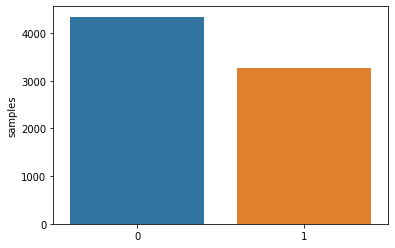

In [10]:

#the number of samples for each class (catastroph tweet or not) 

x=dataset['target'].value_counts()
sns.barplot(x.index,x)
plt.gca().set_ylabel('samples')

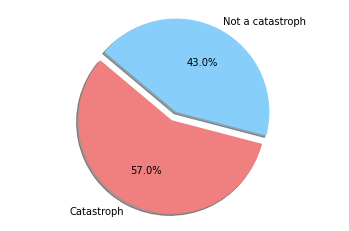

In [11]:
# % of each class from the total of the dt
y = dataset['target'].value_counts(normalize=True)

# Data to plot
labels = 'Catastroph', 'Not a catastroph'
sizes = [y[0],y[1]]
colors = ['lightcoral', 'lightskyblue']
explode = (0.1, 0)  # explode 1st slice

# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')
plt.show()

#### Overall view of our data (we have some missing locatoins)

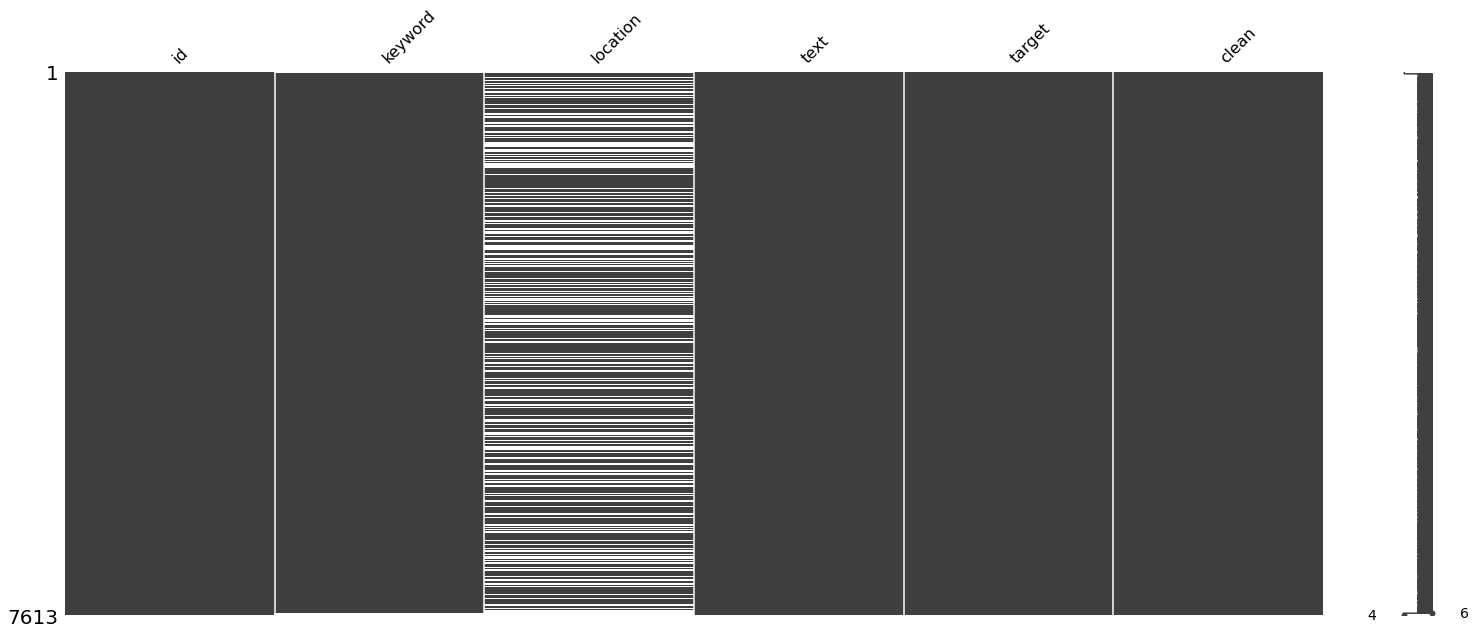

In [12]:
msno.matrix(dataset)

#### Bar chart over view of our data and we notice that 

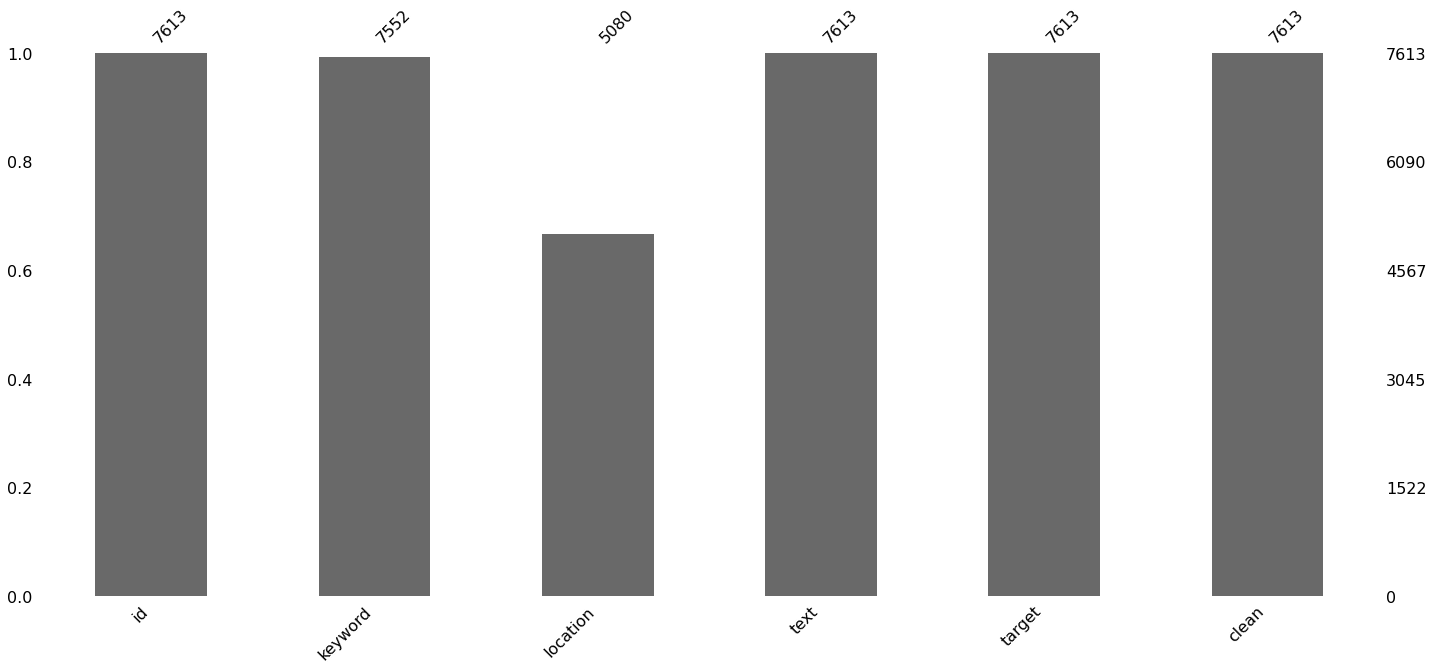

In [13]:
# (the most missing character is the location)
msno.bar(dataset)

#### Correlation between variables

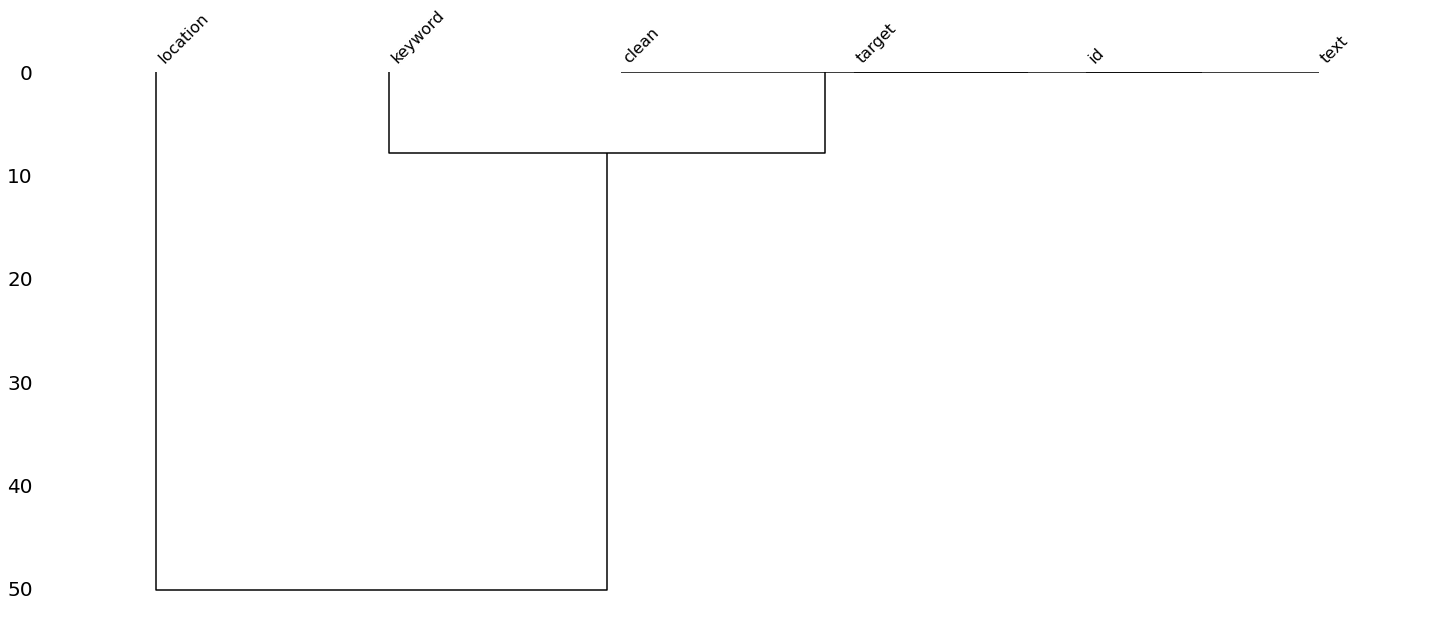

In [14]:
msno.dendrogram(dataset)

#### Length of the words for Disaster tweets 

Text(0.5, 1.0, 'Length of words (disaster tweets clean)')

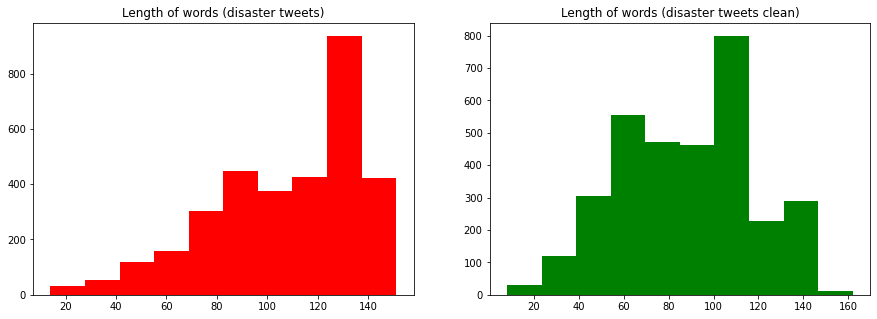

In [15]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
ax1.hist(dataset[dataset['target']==1]['text'].str.len(),color='red')
ax1.set_title('Length of words (disaster tweets)')

ax2.hist(dataset[dataset['target']==1]['clean'].str.len(),color='green')
ax2.set_title('Length of words (disaster tweets clean)')

#### Length of the words for non Disaster tweets

Text(0.5, 1.0, 'Length of words (Non Disaster Tweets clean)')

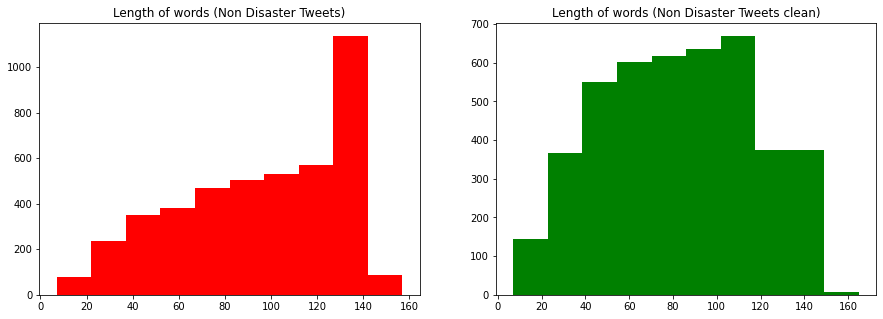

In [16]:

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
ax1.hist(dataset[dataset['target']==0]['text'].str.len(),color = 'red')
ax1.set_title('Length of words (Non Disaster Tweets)')

ax2.hist(dataset[dataset['target']==0]['clean'].str.len(),color = 'green')
ax2.set_title('Length of words (Non Disaster Tweets clean)')

#### Map of our number of twets per country

In [17]:
Loc = dataset['location'].value_counts()
fig = px.choropleth(Loc.values, locations=Loc.index,
                    locationmode='country names',
                    color=Loc.values,
                    color_continuous_scale=px.colors.sequential.OrRd)
fig.update_layout(title="Distribution number tweet per country")
py.iplot(fig, filename='test')


#### Displaying the most used word (clean version)

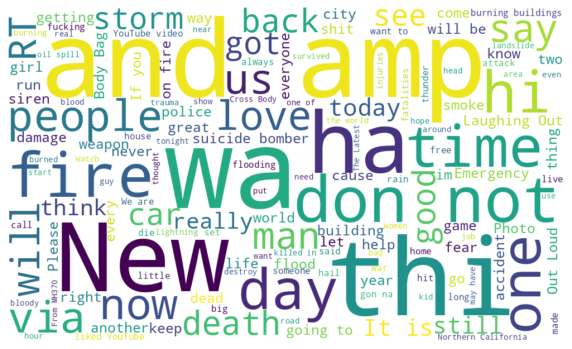

In [18]:

wordcloud = WordCloud(width = 1000, height = 600, max_font_size = 200, max_words = 150,
                      background_color='white').generate(" ".join(dataset['clean']))

plt.figure(figsize=[10,10])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#### Displaying the most used words (before cleaning)

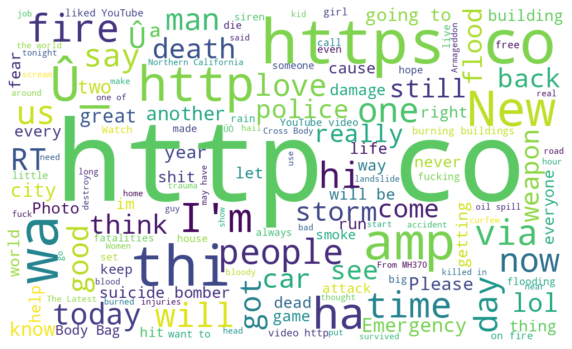

In [19]:
wordcloud = WordCloud(width = 1000, height = 600, max_font_size = 200, max_words = 150,
                      background_color='white').generate(" ".join(dataset['text']))

plt.figure(figsize=[10,10])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#### Most used keywords

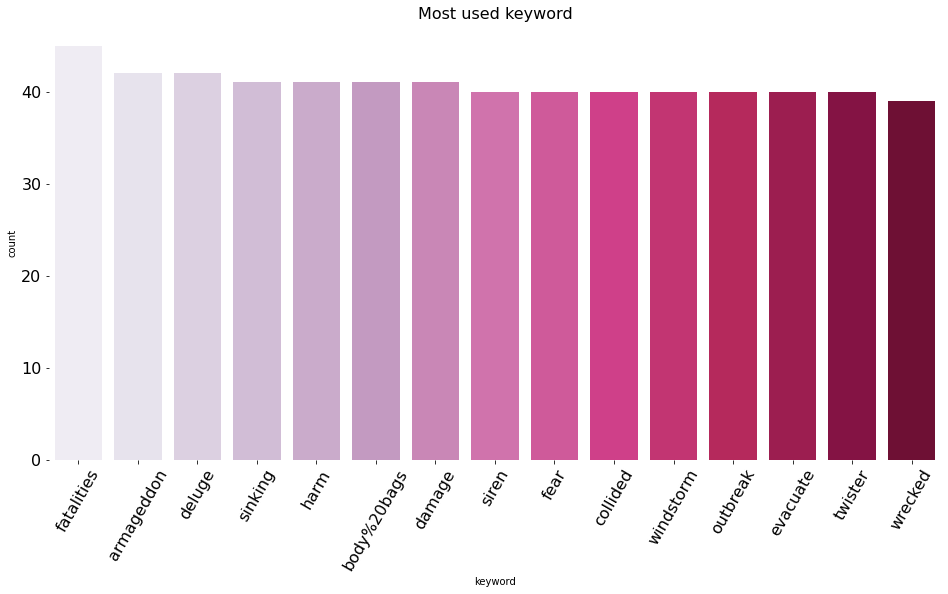

In [20]:
plt.figure(figsize=(16,8))
plt.title('Most used keyword',fontsize=16)
plt.xlabel('keywords')

sns.countplot(dataset['keyword'],order=pd.value_counts(dataset['keyword']).iloc[:15].index,palette=sns.color_palette("PuRd", 15))

plt.xticks(size=16,rotation=60)
plt.yticks(size=16)
sns.despine(bottom=True, left=True)
plt.show()

## Part three : Machine Learning

#### Pipeline for linear regression

In [21]:
pipe_linReg = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', LinearRegression()),
])
pipe_linReg.fit(X_train, y_train)
pipe_linReg.score(X_test, y_test)

-0.3725118775117628

#### Creating an evaluate function for the error and accuracy

In [22]:
def evaluate(model, X_test, y_test):
    predictions = model.predict(X_test)
    errors = abs(predictions - y_test)
    accuracy = accuracy_score(y_test, predictions)*100
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy

#### Pipeline for logistic Regression

In [23]:
pipe_logReg = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', LogisticRegression(solver='liblinear')),
])
pipe_logReg.fit(X_train, y_train)
accuracy_logReg = evaluate(pipe_logReg,X_test,y_test)

Model Performance
Average Error: 0.1871 degrees.
Accuracy = 81.29%.


#### Pipeline for Gaussian Classifier

In [24]:
#adding of a function to the pipeline to create a dense array

class DenseTransformer(TransformerMixin):

    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None, **fit_params):
        return X.todense()
    
pipe_gaus = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('to_dense', DenseTransformer()), 
    ('clf', GaussianNB()),
])

pipe_gaus.fit(X_train, y_train)
accuracy_gaus = evaluate(pipe_gaus,X_test,y_test)

Model Performance
Average Error: 0.3828 degrees.
Accuracy = 61.72%.


#### Pipeline for BernoulliNB Classifier

In [25]:
pipe_ber = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('to_dense', DenseTransformer()), 
    ('clf', BernoulliNB()),
])

pipe_ber.fit(X_train, y_train)
accuracy_ber = evaluate(pipe_ber,X_test,y_test)

Model Performance
Average Error: 0.1996 degrees.
Accuracy = 80.04%.


#### Pipeline for MultinomialNB Classifier

In [26]:
pipe = Pipeline([
    ('vect', CountVectorizer(ngram_range =(1,1))),
    ('tfidf', TfidfTransformer(use_idf = False)),
    ('clf', MultinomialNB(alpha= 0.01)),
])


pipe.fit(X_train, y_train)
accuracy_ber = evaluate(pipe,X_test,y_test)

Model Performance
Average Error: 0.2114 degrees.
Accuracy = 78.86%.


#### Pipeline for Random Forest Classifier

In [27]:
pipe_rfc = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('to_dense', DenseTransformer()), 
    ('clf', RandomForestClassifier()),
])

pipe_rfc.fit(X_train, y_train)
accuracy_ber = evaluate(pipe_rfc,X_test,y_test)

Model Performance
Average Error: 0.2213 degrees.
Accuracy = 77.87%.


#### Pipeline for SVC model

In [ ]:
pipe_SVC = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('to_dense', DenseTransformer()), 
    ('clf', SVC()),
])

pipe_SVC.fit(X_train, y_train)
accuracy_ber = evaluate(pipe_SVC,X_test,y_test)

#### Pipeline for KNeighbors Classifier

In [ ]:
pipe_knn = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf',  KNeighborsClassifier()),
    ])
pipe_knn.fit(X_train, y_train)
accuracy_ber = evaluate(pipe_knn,X_test,y_test)

#### Best parameters for the logistic Regression

In [ ]:
param_grid = {'clf' : [LogisticRegression()],
     'clf__penalty' : ['l1', 'l2',],
    'clf__C' : np.logspace(-4, 4, 20),
    'clf__solver' : ['liblinear', 'saga']},

# Create grid search object

clf = GridSearchCV(pipe_logReg, param_grid = param_grid, cv = 5, verbose=True, n_jobs=-1)

best_clf = clf.fit(X_train, y_train)

In [ ]:
best_clf.best_params_

In [ ]:
best_clf.best_score_

#### Pipeline for logistic Regression with the best parameters

In [ ]:
pipe_logReg = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', LogisticRegression(solver='saga',C= 1.623776739188721,
 penalty= 'l2',)),
])
pipe_logReg.fit(X_train, y_train)
predictions = pipe_logReg.predict(X_test)
accuracy_logReg = evaluate(pipe_logReg,X_test,y_test)

## Part four : Visualization

#### Confusion matrix

In [ ]:
cm = metrics.confusion_matrix(y_test, predictions)
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'
plt.title(all_sample_title, size = 15);

In [ ]:
tn, fp, fn, tp = cm.ravel()
print(f'True Positives: {tp}')
print(f'False Positives: {fp}')
print(f'True Negatives: {tn}')
print(f'False Negatives: {fn}')

#### Showcase of the miss classified tweets

In [ ]:
index = 0
misclassifiedIndexes = []
for label, predict in zip(y_test, predictions):
 if label != predict: 
  misclassifiedIndexes.append(index)
 index +=1

In [ ]:
index = 0
for i in X_test :
    if(index in misclassifiedIndexes):
        print(i)
        print('=============================')
    index += 1

#### AUC ROC curve

In [ ]:
probas = pipe_logReg.predict_proba(X_test)[:, 1]
def get_preds(threshold, probabilities):
    return [1 if prob > threshold else 0 for prob in probabilities]
roc_values = []
for thresh in np.linspace(0, 1, 100):
    preds = get_preds(thresh, probas)
    tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
    tpr = tp/(tp+fn)
    fpr = fp/(fp+tn)
    roc_values.append([tpr, fpr])
tpr_values, fpr_values = zip(*roc_values)
fig, ax = plt.subplots(figsize=(10,7))
ax.plot(fpr_values, tpr_values)
ax.plot(np.linspace(0, 1, 100),
         np.linspace(0, 1, 100),
         label='baseline',
         linestyle='--')
plt.title('Receiver Operating Characteristic Curve', fontsize=18)
plt.ylabel('TPR', fontsize=16)
plt.xlabel('FPR', fontsize=16)
plt.legend(fontsize=12);